###Adversarial Attacks###

In this report Adversarial Attacks on Neural Networks are considered. 

- Initially three models are trained using common Convolutional Neural Network architectures. 

- Then using the resulting weights the Fast Gradient Sign Method is implemented.

- The results are then compared for different levels of pertubation for all three architectures. 


In [ ]:
import os
from google.colab import drive
#drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)
path = "/content/gdrive/My Drive/Colab Notebooks"
os.chdir(path)

Mounted at /content/gdrive


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [ ]:
import os
print(os.getcwd())

/content/gdrive/My Drive/Colab Notebooks


Begin by importing the neccassery libraries for defining and training a Neural Network.

- Pytorch is the main library for Neural Networks it provides us with the framework for creating our Neural Network architecture and has the useful feature of automatic differentiation useful in the backpropagation algorithm. Along with this it has many other useful functions like we can use different optimizers and change batch sizes and so on. Also we can move the calcuations to the GPU this decreases training time considerably and is one of the breakthroughs for CNNs. 

- Torchvision is a package that allows us to import datasets that are well known relativily easily and means that we do not need to waste time preprocessing the data and it is ready to to use as input for our model. 

- Numpy allows us to do the numerical computations effeciently and is needed for all the matrix computations. 

- Matplotlib is a library that provides with a toolkit for creating visualizations and very useful for displaying images and can be used to display feature maps and filters. 

## Importing all the libraries ##

In [ ]:
# Import libraries 
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

### Defining our Neural Net ###



Convolutional Neural Networks are the default choice for computer vision. Why it might be asked another ANN architecture not be used. For instance Multilayer Perceptrons. In such a case the image would need to be flattened this means even a small 28x28 image which has 784 pixels where each pixel is a feature, our input layer needs 784 inputs if we even have a few layers it is evident that the number of connections and thus weights will be quite large and the amount of time that is taken to train such a model will be execesive. 

Convolutional Neural Nets make use of the heirachical structure of the data in this case images. They are made of low level features like lines which combine together to form shapes. They have many useful feautures that make them suitable for image classification. There structure is not too different from ANNs however there are some key differences namely, the convolutional layer, pooling layers and drop out layers. Each serve a different purpose and together they are very powerful and unrivaled in the area of computer vision. 

Part of their strength is that the data requires very little preprocessing and the filters learn by themselves the important features this is very different from normal neural nets where they are largely uninterpretible and we can not clearly see what decisions the model is making here we can clearly see in the filters and feature maps what our model "sees" and what it uses to identify certain things.  

There structure is roughly as follows. An input layer which unlike MLP does not need to be flattened so it can take a 2D input for a greyscale image like MNIST or 3D for a 3 channel image RGB such as CIFAR-10. The output layer has the number of classes. The interesting part is the hidden layers. A Neural Net is convolutional if at least one of its hidden layers is convolutional. What follows a convolutional layer is normally a pooling layer. There are different arrangements and combinations of convolutional and pooling layers, they can even be stacked ontop of eachother. We also have dropout layers they serve the purpose of preventing overfitting by randomly shutting of certain neurons during testing. Before the final layer we then have some fully connected layers and then the output layer which depends on the data in this case softmax for classification. 

I will now go through each of the different types of layers in detail:

- Input Layer 

This is the first layer in our Neural Net its size is determined by the size of the input. If we limit the discussion to images that the resolution of the image determines the input layer. It is possible the layer be larger say if padding was used. 

- Convolutional Layer 

In a CNN at least one of the hidden layers is a convolutional layer. The convolutional layer takes is not fully connected it is connected to a limited number of neurons from the previous layer. This is for several reasons. Images tend to be made up low level feautures which combine together. Therefore it is only neccassery to capture a portion of input which can be combined and used to create high level features at a later stage. CNN's becuase they are not fully connected self regularize. Convolutional layers work by selecting a filter size then finding weights for these filters. 

- Pooling Layer 

Pooling layers are similar to Convolutional layers they work by aggregating the output of a layer using some function, the most popular is max pool. This takes the pixel with the highest intensity. This is a dimension reduction technique. 

- Dropout Layer 

Dropout layers are used to regulurize our network i.e to stop it from overfitting. It works by stopping the network having an over reliance on any single neuron. It can be implemented in several different ways. We can shut off neurons during the training stage selectivly or we can randomly do this also. 

- Fully connected regime 

As part of a CNN's architecture the last layers are usually dense. These final fully connected layers combine all the lower level features found by the convolutional layer. 

- Output Layer

This is the final layer in our network and in a classification problem its size is determined by the number of classes. 

- Batch Normalization

This helps with the problem of exploding and vanishing gradients a problem in deep networks. Batch normalization is often combined with convolutional layers and allows us to use saturating activation functions. 

Hyperparameters 

- Stride 

This determines the change from the input to the output size. 

- Padding 

These are extra pixels put around the image to maintain the input and output size at each layer.
There is zero padding and just using the nearest value. 

- filter size 

The filter size is what a neuron sees some times called the receptive field. 

Other features

- Loss function 

The loss or cost function penalizes incorrect predictions. We wish to minimize this so the model makes as few mistakes as possible. 


- Activation function 

The function like sigmoid or relu that takes a weighted sum as its input then outputs a number. Its choice is very important and should be carefully considered. 

- Optimizer

The optimizer is what helps us to minimize the loss function. Often an anlytic solution does not exist or is computationaly difficult to compute. 





#Net#

In [ ]:
# Neural Network Architecture 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding = 1)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2, 2)
        self.globalavgpool = nn.AvgPool2d(8, 8)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout50 = nn.Dropout(0.5)
        self.dropout10 = nn.Dropout(0.1)
        self.fc = nn.Linear(256, 10)

# Forward function    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.dropout10(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.avgpool(x)
        x = self.dropout10(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.globalavgpool(x)
        x = self.dropout50(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Above is a custom architecture the main feautures of this are 

- Three stacked convolutional kernals. Stacked convolutional kernals are very useful and serve two main purposes. Dicounting the first layer if we wish to increase the receptive field of a kernal we should stack two layers on top of eachother. Also it adds non-linearity to the model making it more powerful. 

- Pooling Layers it uses three time average,max and global average pooling. 

- Uses Relu activation function  this is the default activation function and very fast to compute. It does have some issues but they are mostly addressed by its many variants such as leaky Relu and PRelu

- Before the last layer there is a dropout layer to prevent overfitting then the input in flattenend (requires 1D input) so it can be ready for the fully connected layer.

#LeNet-5#


In [ ]:
# Neural Net architecture for lenet-5
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

# Forward function 
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

Above is the architecture of the lenet-5 Neural Net. It is very simple and consists of only a few hidden layers. It is very famous and was used by the banks to check the digits on hand written cheques. 

#ResNet#

In [ ]:
# Neural Net architecture for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

This is the ResNet architecture. It is somewhat more complicated then the preceding Networks. Also it is not a simple FeedFoward Network, where layers are only connected to preceeding layers. We have skip layers now. 

## Define FGSM function

An Adversarial Attack is an attempt to cause a classifier to misclassify an image that it is presented with. Whilst Neural Networks are incredibly powerful and have unrivalled classification rates it is remarkably simple to fool them to misclassify the image they are shown.Part of the problem with Neural Nets is there interpretability.  Humans can perceive things in a way that Neural Nets cannot, but do not think humans cannot be tricked there are numerous illusions that many will be familiar with.  This is a problem if we consider the modern world and AI for example self-driving cars. 

There are several cases or types of attack that can be considered. For instance are we interested in the output class of the image or do we simply require that the image is misclassified ?

Do we have information such as the architecture and weights of the model we wish to fool, or do we just know the output and input classes?

The approach we pursue will depend on the answers to the above and are summarised below.
Targeted (Here we want to fool the classifier to a specific class) / Untargeted (We do not care about the output class just that it is different from the ground truth) / Black box (Nothing about the model weights or its architecture is known only the corresponding inputs and outputs) / White box (All the details of the model are known) 

A single channel 28x28 image is made up of 784 pixels each pixel is represented by its intensity 0-255. 
We wish to fool a classifier subject to the requirement that any alteration that we make to the image be minimal. A norm that penalises changes is needed. Some commonly used are the p norm or l norm. 
The perturbation applied should be imperceptible, that is a human looking at the image should not be able to see the input has been tampered with.
A successful attack is one which fools the classifier without being noticed by the user. 


Here is the fgsm function from the pytorch tutorial. 

The function takes three arguments the base image epsilon the amount of pertubation and the data_gradient. 

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Importing Data and Transform

Torchvision is used to import the data and is used so that we do not need to worry about the preprocessing of the data. It is a very useful tool especially if you are interested in quickly validating your model using a well known dataset.  

Data Augamentation 

- To train a deep Neural Net a large amount of labelled training data is required in the literature around 100K is an often referenced number. This sometimes is often not possible so data augamentation can be used to artificially increase the size of the training data. This is done by applying transformations, rotations and changing the contrast of images. It can increase the size of the data set by around 50x and makes the network invariant to small changes. It regularizes the model and stops overfitting. 



In [ ]:
import imgaug.augmenters as iaa
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

pic_size = 32
aug = iaa.Sequential([
        iaa.Affine(
        scale=(0.8, 1.2), 
        rotate=(-5, 5), 
        order=[0],),
        iaa.PadToFixedSize(pic_size, pic_size),
        iaa.CropToFixedSize(pic_size, pic_size),
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=1.0)),
        iaa.Sometimes(0.5, iaa.SaltAndPepper(0.06, per_channel=True)),
        ])

In [ ]:
class CIFAR10_iaa(datasets.CIFAR10):
    def __getitem__(self, idx):
        pil, target = super().__getitem__(idx)
        img = aug(image=np.array(pil)) / 255
        return img.transpose((2, 0, 1)), target

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Enter the training and testing batch size 
train_batch_size = 100
test_batch_size = 1

# To use autgrad we must convert to tensor
transform = transforms.Compose(
    [transforms.ToTensor(),])

# Import CIFAR10 and specify batch size 

# Training data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=2)

# Testing data
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

# Specify the classes in the dataset 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Training of model

### Init Net and Device

In [ ]:
# Use the GPU if available to speed up training 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:2")
net = Net().train().to(device)
lenet = LeNet().train().to(device)
resnet = ResNet18().train().to(device)

###Summary of the architecture for all three networks###

In [ ]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2           [-1, 64, 32, 32]          36,928
         MaxPool2d-3           [-1, 64, 16, 16]               0
           Dropout-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
            Conv2d-6          [-1, 128, 16, 16]         147,584
         AvgPool2d-7            [-1, 128, 8, 8]               0
           Dropout-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
           Conv2d-10            [-1, 256, 8, 8]         590,080
        AvgPool2d-11            [-1, 256, 1, 1]               0
          Dropout-12            [-1, 256, 1, 1]               0
           Linear-13                   [-1, 10]           2,570
Total params: 1,147,978
Trainable param

In [ ]:
summary(lenet,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [ ]:
summary(resnet,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

### Selecting the loss function and optimizer


Selecting the optimiser is very important on large data sets using gradient descent or batch gradient descent is not feasible so we must select another. The default is Stochastic Gradient Descent here Adam is used there are others available and can be experimented with such as RMSPROP. Adam is an adaptive variant of Stochastic Gradient Descent. It utilises different learning rates for different parameters.

Also we can see cross entropy loss is used. Cross entropy measures and penalizes our model depending on whether its prediction matches the base truth and the strength of this prediction.

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer_net = optim.Adam(net.parameters(), lr=0.001)
optimizer_lenet = optim.Adam(lenet.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.001)

### Training and saving the weights of the each model

In [ ]:
%%time
epochs = 10
for epoch in range(epochs):
    running_loss = 0.
    for i, data in enumerate(trainloader):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_net.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_net.step()
        
        if (i+1) % 100 == 0:
            print('[%d, %5d] loss: %.4f' %(epoch + 1, (i+1)*train_batch_size, loss.item()))

print('Finished Training')
torch.save(net.state_dict(), './cifar10_net.pth')

[1, 10000] loss: 2.0458
[1, 20000] loss: 1.9338
[1, 30000] loss: 1.7630
[1, 40000] loss: 1.6730
[1, 50000] loss: 1.5610
[2, 10000] loss: 1.6417
[2, 20000] loss: 1.5879
[2, 30000] loss: 1.4433
[2, 40000] loss: 1.7247
[2, 50000] loss: 1.4355
[3, 10000] loss: 1.3106
[3, 20000] loss: 1.4207
[3, 30000] loss: 1.3591
[3, 40000] loss: 1.2209
[3, 50000] loss: 1.2326
[4, 10000] loss: 1.1032
[4, 20000] loss: 1.2065
[4, 30000] loss: 1.0471
[4, 40000] loss: 1.1625
[4, 50000] loss: 1.0990
[5, 10000] loss: 0.9588
[5, 20000] loss: 1.0296
[5, 30000] loss: 0.9145
[5, 40000] loss: 0.9370
[5, 50000] loss: 0.9488
[6, 10000] loss: 0.8890
[6, 20000] loss: 0.9637
[6, 30000] loss: 0.8035
[6, 40000] loss: 0.9849
[6, 50000] loss: 0.9404
[7, 10000] loss: 0.8142
[7, 20000] loss: 1.1104
[7, 30000] loss: 0.9531
[7, 40000] loss: 0.9807
[7, 50000] loss: 0.8908
[8, 10000] loss: 0.8111
[8, 20000] loss: 0.8205
[8, 30000] loss: 0.9020
[8, 40000] loss: 0.7845
[8, 50000] loss: 0.9036
[9, 10000] loss: 0.7346
[9, 20000] loss:

In [ ]:
%%time
epochs = 10
for epoch in range(epochs):
    running_loss = 0.
    for i, data in enumerate(trainloader):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_lenet.zero_grad()
        
        outputs = lenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_lenet.step()
        
        if (i+1) % 100 == 0:
            print('[%d, %5d] loss: %.4f' %(epoch + 1, (i+1)*train_batch_size, loss.item()))

print('Finished Training')
torch.save(lenet.state_dict(), './cifar10_lenet.pth')

[1, 10000] loss: 1.8518
[1, 20000] loss: 1.7383
[1, 30000] loss: 1.6483
[1, 40000] loss: 1.6215
[1, 50000] loss: 1.4112
[2, 10000] loss: 1.4330
[2, 20000] loss: 1.4523
[2, 30000] loss: 1.4943
[2, 40000] loss: 1.5443
[2, 50000] loss: 1.4060
[3, 10000] loss: 1.3764
[3, 20000] loss: 1.4191
[3, 30000] loss: 1.3587
[3, 40000] loss: 1.1262
[3, 50000] loss: 1.3903
[4, 10000] loss: 1.2965
[4, 20000] loss: 1.4262
[4, 30000] loss: 1.3086
[4, 40000] loss: 1.3197
[4, 50000] loss: 1.2511
[5, 10000] loss: 1.4237
[5, 20000] loss: 1.1058
[5, 30000] loss: 1.2847
[5, 40000] loss: 1.2106
[5, 50000] loss: 1.1819
[6, 10000] loss: 1.2585
[6, 20000] loss: 1.1997
[6, 30000] loss: 1.1290
[6, 40000] loss: 1.1281
[6, 50000] loss: 1.2251
[7, 10000] loss: 1.1976
[7, 20000] loss: 1.1328
[7, 30000] loss: 1.0363
[7, 40000] loss: 1.2337
[7, 50000] loss: 1.3378
[8, 10000] loss: 1.0624
[8, 20000] loss: 1.2918
[8, 30000] loss: 1.2419
[8, 40000] loss: 0.9230
[8, 50000] loss: 1.2838
[9, 10000] loss: 1.2371
[9, 20000] loss:

In [ ]:
%%time
epochs = 10
for epoch in range(epochs):
    running_loss = 0.
    for i, data in enumerate(trainloader):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_resnet.zero_grad()
        
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        
        if (i+1) % 100 == 0:
            print('[%d, %5d] loss: %.4f' %(epoch + 1, (i+1)*train_batch_size, loss.item()))

print('Finished Training')
torch.save(resnet.state_dict(), './cifar10_resnet.pth')

[1, 10000] loss: 1.4620
[1, 20000] loss: 1.4030
[1, 30000] loss: 1.3101
[1, 40000] loss: 1.0417
[1, 50000] loss: 1.0489
[2, 10000] loss: 0.8957
[2, 20000] loss: 0.7791
[2, 30000] loss: 0.8098
[2, 40000] loss: 0.7184
[2, 50000] loss: 0.7826
[3, 10000] loss: 0.6976
[3, 20000] loss: 0.6272
[3, 30000] loss: 0.6257
[3, 40000] loss: 0.6254
[3, 50000] loss: 0.6538
[4, 10000] loss: 0.5311
[4, 20000] loss: 0.5357
[4, 30000] loss: 0.5554
[4, 40000] loss: 0.5098
[4, 50000] loss: 0.4877
[5, 10000] loss: 0.2592
[5, 20000] loss: 0.4607
[5, 30000] loss: 0.3631
[5, 40000] loss: 0.3851
[5, 50000] loss: 0.4417
[6, 10000] loss: 0.2543
[6, 20000] loss: 0.2595
[6, 30000] loss: 0.4753
[6, 40000] loss: 0.2287
[6, 50000] loss: 0.3357
[7, 10000] loss: 0.1933
[7, 20000] loss: 0.1758
[7, 30000] loss: 0.2064
[7, 40000] loss: 0.2163
[7, 50000] loss: 0.2206
[8, 10000] loss: 0.1105
[8, 20000] loss: 0.1598
[8, 30000] loss: 0.1630
[8, 40000] loss: 0.1436
[8, 50000] loss: 0.1663
[9, 10000] loss: 0.0968
[9, 20000] loss:

### Load weights

In [ ]:
# Loading the weights of the pretrained models
net.load_state_dict(torch.load('./cifar10_net.pth', map_location='cpu'))
lenet.load_state_dict(torch.load('./cifar10_lenet.pth', map_location='cpu'))
resnet.load_state_dict(torch.load('./cifar10_resnet.pth', map_location='cpu'))

<All keys matched successfully>

### Evaluate the mode & fix the weights

In [ ]:
net.eval()
for p in net.parameters():
    p.requires_grad = False

In [ ]:
lenet.eval()
for p in lenet.parameters():
    p.requires_grad = False

In [ ]:
resnet.eval()
for p in resnet.parameters():
    p.requires_grad = False

### Accuracy of the Net model 

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the Net network on the 10000 test images: %d %%' % (
    100 * correct / total))
 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(test_batch_size):
            label = labels[i]
#           class_correct[label] += c[i].item()
            class_correct[label] += c.item()
            class_total[label] += 1
 
 
for i in range(10):
    print('Net Network: Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the Net network on the 10000 test images: 77 %
Net Network: Accuracy of plane : 86 %
Net Network: Accuracy of   car : 93 %
Net Network: Accuracy of  bird : 61 %
Net Network: Accuracy of   cat : 57 %
Net Network: Accuracy of  deer : 75 %
Net Network: Accuracy of   dog : 64 %
Net Network: Accuracy of  frog : 84 %
Net Network: Accuracy of horse : 79 %
Net Network: Accuracy of  ship : 87 %
Net Network: Accuracy of truck : 82 %


### Accuracy of the LeNet-5 model 

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = lenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the LeNet network on the 10000 test images: %d %%' % (
    100 * correct / total))
 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = lenet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(test_batch_size):
            label = labels[i]
#           class_correct[label] += c[i].item()
            class_correct[label] += c.item()
            class_total[label] += 1
 
 
for i in range(10):
    print('LeNet Network: Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the LeNet network on the 10000 test images: 59 %
LeNet Network: Accuracy of plane : 73 %
LeNet Network: Accuracy of   car : 74 %
LeNet Network: Accuracy of  bird : 51 %
LeNet Network: Accuracy of   cat : 42 %
LeNet Network: Accuracy of  deer : 43 %
LeNet Network: Accuracy of   dog : 44 %
LeNet Network: Accuracy of  frog : 63 %
LeNet Network: Accuracy of horse : 61 %
LeNet Network: Accuracy of  ship : 73 %
LeNet Network: Accuracy of truck : 65 %


### Accuracy of the ResNet model 

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the ResNet network on the 10000 test images: %d %%' % (
    100 * correct / total))
 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(test_batch_size):
            label = labels[i]
#           class_correct[label] += c[i].item()
            class_correct[label] += c.item()
            class_total[label] += 1
 
 
for i in range(10):
    print('ResNet Network: Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the ResNet network on the 10000 test images: 82 %
ResNet Network: Accuracy of plane : 84 %
ResNet Network: Accuracy of   car : 90 %
ResNet Network: Accuracy of  bird : 81 %
ResNet Network: Accuracy of   cat : 68 %
ResNet Network: Accuracy of  deer : 72 %
ResNet Network: Accuracy of   dog : 70 %
ResNet Network: Accuracy of  frog : 87 %
ResNet Network: Accuracy of horse : 93 %
ResNet Network: Accuracy of  ship : 84 %
ResNet Network: Accuracy of truck : 93 %


Interestingly all three networks they had simarlaly poor performance on the bird,cat,deer and dog classes. It is only possible to speculate why this may be as with only this information it cannot be known for certain ,as it appears in all three there it is likely some underlying cause is responsible. A possible approach would be to check the correlation between these classes. 

### Adversarial Attack using FGSM

In [ ]:
# Here we define the function that tests our model
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### Here we run the attacks and evaluate the accuracy for different values of epsilon

In [ ]:
%%time
accuracies_net = []
examples_net = []
epsilons_net = [0, .01, .02, .03, .04, .05, .06,.07,.08,.09,.1]
# Run test for each epsilon
# testloader batchsize should be 1
for eps in epsilons_net:
    acc, ex = test(net, device, testloader, eps)
    accuracies_net.append(acc)
    examples_net.append(ex)

Epsilon: 0	Test Accuracy = 7739 / 10000 = 0.7739
Epsilon: 0.01	Test Accuracy = 4071 / 10000 = 0.4071
Epsilon: 0.02	Test Accuracy = 2080 / 10000 = 0.208
Epsilon: 0.03	Test Accuracy = 1156 / 10000 = 0.1156
Epsilon: 0.04	Test Accuracy = 777 / 10000 = 0.0777
Epsilon: 0.05	Test Accuracy = 595 / 10000 = 0.0595
Epsilon: 0.06	Test Accuracy = 542 / 10000 = 0.0542
Epsilon: 0.07	Test Accuracy = 507 / 10000 = 0.0507
Epsilon: 0.08	Test Accuracy = 506 / 10000 = 0.0506
Epsilon: 0.09	Test Accuracy = 520 / 10000 = 0.052
Epsilon: 0.1	Test Accuracy = 507 / 10000 = 0.0507
CPU times: user 6min 11s, sys: 40.8 s, total: 6min 52s
Wall time: 7min 39s


In [ ]:
%%time
accuracies_net2 = []
examples_net2 = []
epsilons_net2 = [0, .02, .04, .06, .08, .1, .12,.14,.16,.18,.2]

# Run test for each epsilon
# testloader batchsize should be 1
for eps in epsilons_net2:
    acc, ex = test(net, device, testloader, eps)
    accuracies_net2.append(acc)
    examples_net2.append(ex)

Epsilon: 0	Test Accuracy = 7739 / 10000 = 0.7739
Epsilon: 0.02	Test Accuracy = 2080 / 10000 = 0.208
Epsilon: 0.04	Test Accuracy = 777 / 10000 = 0.0777
Epsilon: 0.06	Test Accuracy = 542 / 10000 = 0.0542
Epsilon: 0.08	Test Accuracy = 506 / 10000 = 0.0506
Epsilon: 0.1	Test Accuracy = 507 / 10000 = 0.0507
Epsilon: 0.12	Test Accuracy = 553 / 10000 = 0.0553
Epsilon: 0.14	Test Accuracy = 587 / 10000 = 0.0587
Epsilon: 0.16	Test Accuracy = 629 / 10000 = 0.0629
Epsilon: 0.18	Test Accuracy = 694 / 10000 = 0.0694
Epsilon: 0.2	Test Accuracy = 728 / 10000 = 0.0728
CPU times: user 6min 12s, sys: 40.5 s, total: 6min 52s
Wall time: 7min 36s


In [ ]:
%%time
accuracies_net3 = []
examples_net3 = []
epsilons_net3 = [0, .05, .1, .15, .2, .25, .3,.35,.4,.45,.5]

# Run test for each epsilon
# testloader batchsize should be 1
for eps in epsilons_net3:
    acc, ex = test(net, device, testloader, eps)
    accuracies_net3.append(acc)
    examples_net3.append(ex)

Epsilon: 0	Test Accuracy = 7739 / 10000 = 0.7739
Epsilon: 0.05	Test Accuracy = 595 / 10000 = 0.0595
Epsilon: 0.1	Test Accuracy = 507 / 10000 = 0.0507
Epsilon: 0.15	Test Accuracy = 598 / 10000 = 0.0598
Epsilon: 0.2	Test Accuracy = 728 / 10000 = 0.0728
Epsilon: 0.25	Test Accuracy = 825 / 10000 = 0.0825
Epsilon: 0.3	Test Accuracy = 851 / 10000 = 0.0851
Epsilon: 0.35	Test Accuracy = 875 / 10000 = 0.0875
Epsilon: 0.4	Test Accuracy = 903 / 10000 = 0.0903
Epsilon: 0.45	Test Accuracy = 919 / 10000 = 0.0919
Epsilon: 0.5	Test Accuracy = 944 / 10000 = 0.0944
CPU times: user 6min 13s, sys: 40.8 s, total: 6min 54s
Wall time: 7min 37s


In [ ]:
accuracies_lenet = []
examples_lenet = []
epsilons_lenet = [0, .01, .02, .03, .04, .05, .06,.07,.08,.09,.1]

# Run test for each epsilon
# testloader batchsize should be 1
for eps in epsilons_lenet:
    acc, ex = test(lenet, device, testloader, eps)
    accuracies_lenet.append(acc)
    examples_lenet.append(ex)

Epsilon: 0	Test Accuracy = 5931 / 10000 = 0.5931
Epsilon: 0.01	Test Accuracy = 3037 / 10000 = 0.3037
Epsilon: 0.02	Test Accuracy = 1501 / 10000 = 0.1501
Epsilon: 0.03	Test Accuracy = 757 / 10000 = 0.0757
Epsilon: 0.04	Test Accuracy = 415 / 10000 = 0.0415
Epsilon: 0.05	Test Accuracy = 242 / 10000 = 0.0242
Epsilon: 0.06	Test Accuracy = 146 / 10000 = 0.0146
Epsilon: 0.07	Test Accuracy = 91 / 10000 = 0.0091
Epsilon: 0.08	Test Accuracy = 67 / 10000 = 0.0067
Epsilon: 0.09	Test Accuracy = 55 / 10000 = 0.0055
Epsilon: 0.1	Test Accuracy = 36 / 10000 = 0.0036


In [ ]:
accuracies_resnet = []
examples_resnet = []
epsilons_resnet = [0, .01, .02, .03, .04, .05, .06,.07,.08,.09,.1]

# Run test for each epsilon
# testloader batchsize should be 1
for eps in epsilons_resnet:
    acc, ex = test(resnet, device, testloader, eps)
    accuracies_resnet.append(acc)
    examples_resnet.append(ex)

Epsilon: 0	Test Accuracy = 8256 / 10000 = 0.8256
Epsilon: 0.01	Test Accuracy = 1580 / 10000 = 0.158
Epsilon: 0.02	Test Accuracy = 324 / 10000 = 0.0324
Epsilon: 0.03	Test Accuracy = 125 / 10000 = 0.0125
Epsilon: 0.04	Test Accuracy = 78 / 10000 = 0.0078
Epsilon: 0.05	Test Accuracy = 69 / 10000 = 0.0069
Epsilon: 0.06	Test Accuracy = 74 / 10000 = 0.0074
Epsilon: 0.07	Test Accuracy = 92 / 10000 = 0.0092
Epsilon: 0.08	Test Accuracy = 112 / 10000 = 0.0112
Epsilon: 0.09	Test Accuracy = 137 / 10000 = 0.0137
Epsilon: 0.1	Test Accuracy = 155 / 10000 = 0.0155


### Plots showing the Accuracy vs Epsilon Plots 

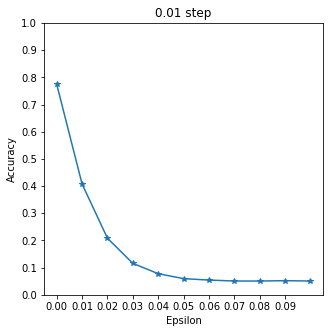

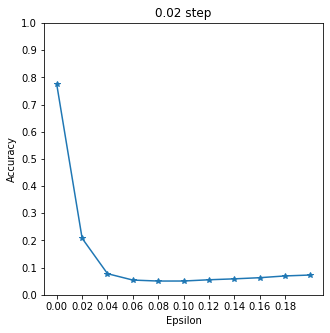

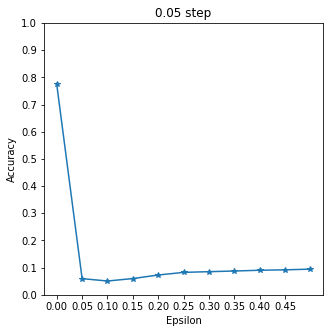

In [ ]:
# Plot of Accuracy vs Epsilon with 0.01 step size 
plt.figure(figsize=(5,5))
plt.plot(epsilons_net, accuracies_net, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .1, step=0.01))
plt.title("0.01 step")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Plot of Accuracy vs Epsilon with 0.02 step size 
plt.figure(figsize=(5,5))
plt.plot(epsilons_net2, accuracies_net2, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .2, step=0.02))
plt.title("0.02 step")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Plot of Accuracy vs Epsilon with 0.05 step size 
plt.figure(figsize=(5,5))
plt.plot(epsilons_net3, accuracies_net3, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .5, step=0.05))
plt.title("0.05 step")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Changing the epsilon value beyond a certain point does not seem to further deteriorate the rate of misclassification in this case around 0.05. This pertubation is small especially compared with the epsillon required in a single channel greyscale image like FashionMNIST. Models that classify three channel images are less robust to adversarial attacks it seems. 

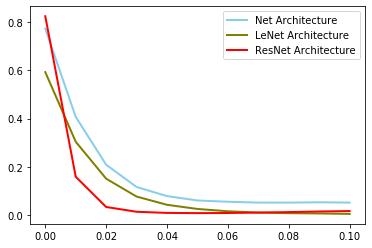

In [ ]:
# Using matplotlib to plot the degradation in accuracy for three different architectures 
plt.plot( epsilons_net, accuracies_net, color='skyblue', linewidth=2, label="Net Architecture")
plt.plot( epsilons_lenet, accuracies_lenet, color='olive', linewidth=2, label="LeNet Architecture")
plt.plot( epsilons_resnet, accuracies_resnet, color='red',linewidth=2, label="ResNet Architecture")
plt.legend()

The three architectures and there response to adversarial attacks. 

The best performing architecture seems to be the least robust. Why this could be? It could be overfitting. 

LeNet performed poorly on the training set it is not surprising that a larger pertubation is required to fool this model. 

Conclusion and summary 

Three Neural Networks were trained then attacked using the fast gradient sign method there robustness varied.

To protect our model we could train it using some adversarial examples, this however would reduce the accuracy of our training data i.e it would be a worse classifier and for that reason it would be harder to attack.  There are other techniques that could be used however there is no simple way to combat adversarial examples what is required is an adaptive method which does not exist.

Further Reading 

- Adversarial training can result in regularization even further regularization than dropout. 

- Models that are easy to optimize are easy to perturb.

- Ensembles are not resistant to adversarial examples.


